**Derek Hessinger and Alexander Lyon**

Spring 2025

CS 444: Deep Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 16})

np.set_printoptions(suppress=True, precision=4)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2


# Project 1: Deep Neural Networks

In this project you will build your own general purpose neural network library! The library is designed to work similarly to modern widely used deep learning libraries, such as Keras and PyTorch. You will write the library in the TensorFlow low-level API, which will make it fast, efficient, and support training on GPUs.

Please do your best to write understandable code that you will want to maintain, as **you will continue to use and augment your neural network library all semester**!

#### Week 1: VGG4 and building a deep learning library

The reason you are building a deep learning library is to learn how to train neural networks that have many layers (i.e. **deep neural networks**). To start, the focus will be on the influential family of deep neural networks called **VGG neural networks**, which was developed several years following the introduction of AlexNet. The [VGG paper](https://arxiv.org/abs/1409.1556) introduces several variants of the network, including VGG11, VGG16, VGG19 (*VGG19 has 19 layers that have weights!!*). This project will culminate in building and training a network from scratch that is comparable to VGG19 on image datasets that are *considerably* larger than we used in CS343!

This week charts the course toward VGG19 with **VGG4**, a much shallower (i.e. smaller) network. While VGG4 has far fewer layers than VGG19, the two share the same fundamental building blocks. VGG4 will be used to test out your deep learning library and establish a baseline for what a 4 layer CNN can do.

## Task 1: Load and processing CIFAR-10 dataset

Before implementing VGG4 and the deep neural network library, let's get familiarized with and write code to preprocess CIFAR-10, a large image dataset that we will use to train the VGG neural networks. CIFAR-10 is similar to STL-10 in that it consists of small color images of natural scenes, but it is considerably larger ($N=60,000$ vs $N=5,000$). Here is some more information about CIFAR-10:
- Each RGB image is 32x32 resolution
- Each image is one of 10 classes: `airplane`, `automobile` `bird` `cat` `deer` `dog` `frog` `horse` `ship` and `truck`
- Unlike STL-10 whose images come from the famous ImageNet dataset, CIFAR-10 images are a subset of the (*also famous*) [80 Million Tiny Images](https://en.wikipedia.org/wiki/80_Million_Tiny_Images) dataset, which was released in 2009.

In [18]:
import datasets

### 1a. Load and preprocess CIFAR-10

Implement the `load_dataset` function in `datasets.py` to load in and preprocess CIFAR-10. For convenience, use TensorFlow Keras to download CIFAR10 directly from the internet.

#### Test: `load_dataset`

Write a line of code to call your `load_dataset` function below. Name your variables in accordance with the test code.

In [19]:
x_train, y_train, x_test, y_test, class_names = datasets.load_dataset('cifar10')

In [20]:
print('The shape of your CIFAR-10 train and test sets are:')
print(f'{x_train.shape=} {y_train.shape=}')
print(f'{x_test.shape=} {y_test.shape=}')
print('and should be:')
print('''x_train.shape=TensorShape([50000, 32, 32, 3]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])''')
print()
print(f'Your training set min/max are {tf.reduce_min(x_train)}/{tf.reduce_max(x_train)} and should be 0.0/1.0')
print(f'The unique set of your train labels are {np.unique(y_train)} and should be [0 1 2 3 4 5 6 7 8 9]')
print(f'The unique set of your test labels are {np.unique(y_test)} and should be [0 1 2 3 4 5 6 7 8 9]')

The shape of your CIFAR-10 train and test sets are:
x_train.shape=TensorShape([50000, 32, 32, 3]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])
and should be:
x_train.shape=TensorShape([50000, 32, 32, 3]) y_train.shape=TensorShape([50000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])

Your training set min/max are 0.0/1.0 and should be 0.0/1.0
The unique set of your train labels are [0 1 2 3 4 5 6 7 8 9] and should be [0 1 2 3 4 5 6 7 8 9]
The unique set of your test labels are [0 1 2 3 4 5 6 7 8 9] and should be [0 1 2 3 4 5 6 7 8 9]


### 1b. Visualize some CIFAR-10 samples

Create a 5x5 grid showing first 25 CIFAR-10 training images in a grid/montage. You should use the class string of each sample as the title and there should not be any clutter created by grid lines/axes.

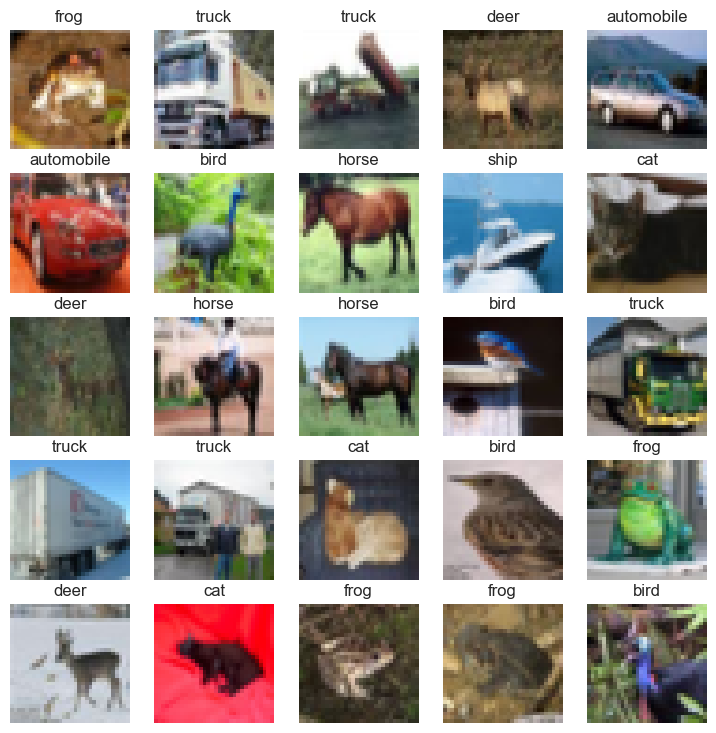

In [21]:
fig, axes, = plt.subplots(nrows=5, ncols=5, figsize=(9, 9))
for i in range(5):
    for j in range(5):
        index = 5*i + j
        ax = axes[i,j]
        ax.imshow(x_train[index])
        ax.set_title(class_names[y_train[index]], fontsize = 12)
        ax.axis("off")  # Remove grid lines and axes


### 1c. Normalize the dataset

Write and test the `standardize` method to normalize the dataset so that it is suitable for training a neural net. 

**Note:** This method uses **global RGB triplet approach** to standardization that we discussed in class. 

#### Test: `standardize`

In [83]:
x_train_pre, x_test_pre = datasets.standardize(x_train, x_test)

print(f'The first few features of the 1st training sample are:\n{x_train_pre[0,0,:2].numpy().ravel()}')
print('and they should be:\n[-1.0526 -0.9817 -0.7625 -1.3066 -1.2394 -1.0324]')
print(f'The last few features of the 1st training sample are:\n{x_train_pre[0,0,-2:].numpy().ravel()}')
print('and they should be:\n[ 0.4237  0.033  -0.1779  0.3602  0.0169 -0.1629]')
print()
print(f'The first few features of the 1st test sample are:\n{x_test_pre[0,0,:2].numpy().ravel()}')
print('and they should be:\n[ 0.519  -0.1764 -0.9724  0.5349 -0.1925 -1.0024]')
print(f'The last few features of the 1st test sample are:\n{x_test_pre[0,0,-2:].numpy().ravel()}')
print('and they should be:\n[ 0.011  -0.5146 -1.1673 -0.1477 -0.6112 -1.2123]')

The first few features of the 1st training sample are:
[-0.1502 -0.1111]
and they should be:
[-1.0526 -0.9817 -0.7625 -1.3066 -1.2394 -1.0324]
The last few features of the 1st training sample are:
[-0.1111 -0.097 ]
and they should be:
[ 0.4237  0.033  -0.1779  0.3602  0.0169 -0.1629]

The first few features of the 1st test sample are:
[1.2486 0.617 ]
and they should be:
[ 0.519  -0.1764 -0.9724  0.5349 -0.1925 -1.0024]
The last few features of the 1st test sample are:
[ 0.617  -0.3018]
and they should be:
[ 0.011  -0.5146 -1.1673 -0.1477 -0.6112 -1.2123]


### 1d. Create train and validation splits

Let's keep the test set as-is and set aside the last portion of training samples to serve as the validation set.

#### Test: `train_val_split`

In [23]:
x_train_split, y_train_split, x_val_split, y_val_split = datasets.train_val_split(x_train, y_train, val_prop=0.2)

print('The shape of your CIFAR-10 train and val sets are:')
print(f'{x_train_split.shape=} {y_train_split.shape=}')
print(f'{x_val_split.shape=} {y_val_split.shape=}')
print('and should be:')
print('''x_train_split.shape=TensorShape([40000, 32, 32, 3]) y_train_split.shape=TensorShape([40000])
x_val_split.shape=TensorShape([10000, 32, 32, 3]) y_val_split.shape=TensorShape([10000])''')
print()
print(f'The first few val class labels are\n{y_val_split[:6]} and they should be\n[1 8 5 1 5 7]')

The shape of your CIFAR-10 train and val sets are:
x_train_split.shape=TensorShape([40000, 32, 32, 3]) y_train_split.shape=TensorShape([40000])
x_val_split.shape=TensorShape([10000, 32, 32, 3]) y_val_split.shape=TensorShape([10000])
and should be:
x_train_split.shape=TensorShape([40000, 32, 32, 3]) y_train_split.shape=TensorShape([40000])
x_val_split.shape=TensorShape([10000, 32, 32, 3]) y_val_split.shape=TensorShape([10000])

The first few val class labels are
[1 8 5 1 5 7] and they should be
[1 8 5 1 5 7]


### 1e. Automate loading and preprocessing for CIFAR-10

Write the `get_dataset` function to automate the process of loading, preprocessing, and creating train/val/test splits in one function.

#### Test: `get_dataset`

In [30]:
x_train, y_train, x_val, y_val, x_test, y_test, classnames = datasets.get_dataset('cifar10', val_prop=0.3)

print('The shape of your CIFAR-10 train, val, and test sets are:')
print(f'{x_train.shape=} {y_train.shape=}')
print(f'{x_val.shape=} {y_val.shape=}')
print(f'{x_test.shape=} {y_test.shape=}')
print('and they should be:')
print('''x_train.shape=TensorShape([35000, 32, 32, 3]) y_train.shape=TensorShape([35000])
x_val.shape=TensorShape([15000, 32, 32, 3]) y_val.shape=TensorShape([15000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])''')

The shape of your CIFAR-10 train, val, and test sets are:
x_train.shape=TensorShape([35000, 32, 32, 3]) y_train.shape=TensorShape([35000])
x_val.shape=TensorShape([15000, 32, 32, 3]) y_val.shape=TensorShape([15000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])
and they should be:
x_train.shape=TensorShape([35000, 32, 32, 3]) y_train.shape=TensorShape([35000])
x_val.shape=TensorShape([15000, 32, 32, 3]) y_val.shape=TensorShape([15000])
x_test.shape=TensorShape([10000, 32, 32, 3]) y_test.shape=TensorShape([10000])


### 1f. Add MNIST support to the preprocessing pipeline

The MNIST dataset will be used as a first test of training the VGG4 net, so let's add support for it in `load_dataset`. Just like with CIFAR-10, use TensorFlow Keras to conveniently load MNIST from the internet.

You may have to explicitly add a trailing color channel dimension (i.e. `n_chans`) to you train/test sets provided by the TensorFlow Keras loader. All that is required here is adding ~4 lines of code total in `load_dataset`. You should NOT need to modify the rest of the preprocessing pipeline.

#### Test: MNIST support

In [32]:
x_train, y_train, x_val, y_val, x_test, y_test, classnames = datasets.get_dataset('mnist', val_prop=0.1)

print('The shape of your MNIST train, val, and test sets are:')
print(f'{x_train.shape=} {y_train.shape=}')
print(f'{x_val.shape=} {y_val.shape=}')
print(f'{x_test.shape=} {y_test.shape=}')
print('and they should be:')
print('''x_train.shape=TensorShape([54000, 28, 28, 1]) y_train.shape=TensorShape([54000])
x_val.shape=TensorShape([6000, 28, 28, 1]) y_val.shape=TensorShape([6000])
x_test.shape=TensorShape([10000, 28, 28, 1]) y_test.shape=TensorShape([10000])''')

print(f'The first few MNIST training features are\n{x_train[0,0,:5, 0]} and should be')
print('[-0.4241 -0.4241 -0.4241 -0.4241 -0.4241]')
print(f'The first few MNIST training labels are\n{y_train[:5]} and should be')
print('[5 0 4 1 9]')
print(f'Some MNIST val features from 1st sample are\n{x_val[0,4:8,13, 0]} and should be')
print('[-0.4241 -0.055   2.5288  2.7961]')
print(f'The first few MNIST val labels are\n{y_val[:5]} and should be')
print('[5 3 5 0 0]')

The shape of your MNIST train, val, and test sets are:
x_train.shape=TensorShape([54000, 28, 28, 1]) y_train.shape=TensorShape([54000])
x_val.shape=TensorShape([6000, 28, 28, 1]) y_val.shape=TensorShape([6000])
x_test.shape=TensorShape([10000, 28, 28, 1]) y_test.shape=TensorShape([10000])
and they should be:
x_train.shape=TensorShape([54000, 28, 28, 1]) y_train.shape=TensorShape([54000])
x_val.shape=TensorShape([6000, 28, 28, 1]) y_val.shape=TensorShape([6000])
x_test.shape=TensorShape([10000, 28, 28, 1]) y_test.shape=TensorShape([10000])
The first few MNIST training features are
[-0.4241 -0.4241 -0.4241 -0.4241 -0.4241] and should be
[-0.4241 -0.4241 -0.4241 -0.4241 -0.4241]
The first few MNIST training labels are
[5 0 4 1 9] and should be
[5 0 4 1 9]
Some MNIST val features from 1st sample are
[-0.4241 -0.055   2.5288  2.7961] and should be
[-0.4241 -0.055   2.5288  2.7961]
The first few MNIST val labels are
[5 3 5 0 0] and should be
[5 3 5 0 0]
